In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('Data.xlsx')

# Ensure 'Sales' is numeric and handle missing values
print("\nProcessing Sales column...")
if 'Sales' not in df.columns:
    print("❌ Error: 'Sales' column not found in the dataset")
    exit()

df['Sales'] = pd.to_numeric(df['Sales'], errors='coerce')
initial_rows = len(df)
df = df.dropna(subset=['Sales'])
print(f"✓ Removed {initial_rows - len(df)} rows with missing Sales values")

# Check if we have enough data
if len(df) < 20:
    print("❌ Error: Insufficient data for modeling (less than 20 rows)")
    exit()

# EXPLORATORY DATA ANALYSIS
print("\nDataset Info:")
print(f"Sales range: ${df['Sales'].min():,.0f} - ${df['Sales'].max():,.0f}")
print(f"Mean Sales: ${df['Sales'].mean():,.0f}")


Processing Sales column...
✓ Removed 0 rows with missing Sales values

Dataset Info:
Sales range: $737,662 - $3,226,827
Mean Sales: $1,563,810


In [3]:
# Check for missing values
missing_summary = df.isnull().sum()
missing_count = missing_summary.sum()
print(f"\nMissing Values: {missing_count} total")


Missing Values: 429 total


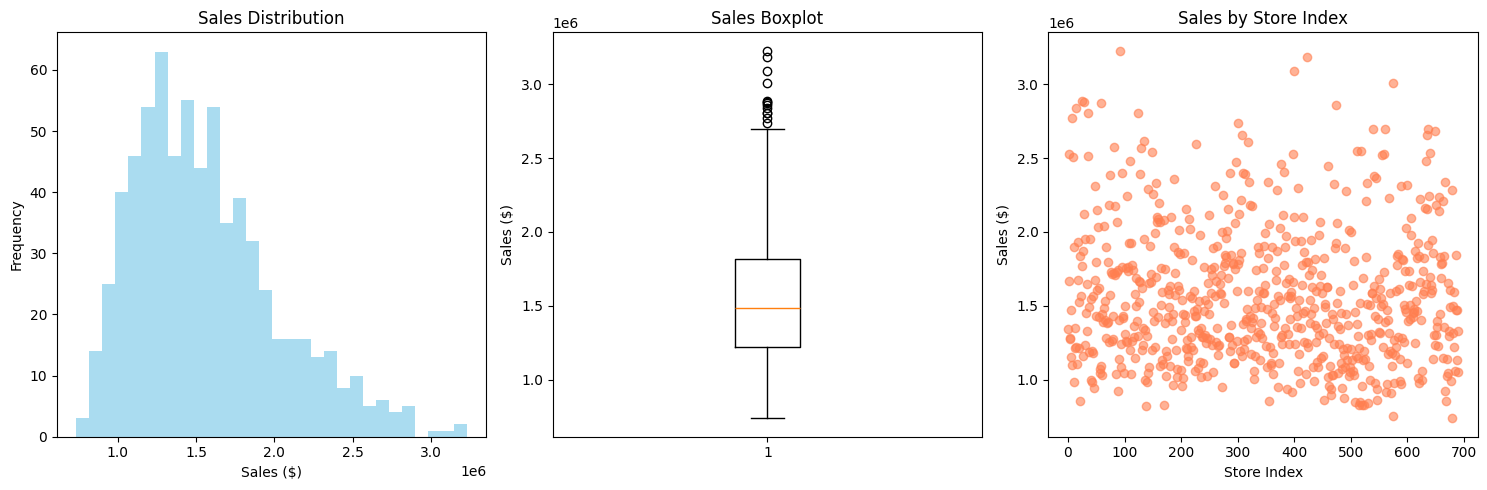

In [4]:
# Sales distribution visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df['Sales'], bins=min(30, len(df)//5), alpha=0.7, color='skyblue')
plt.title('Sales Distribution')
plt.xlabel('Sales ($)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.boxplot(df['Sales'])
plt.title('Sales Boxplot')
plt.ylabel('Sales ($)')

plt.subplot(1, 3, 3)
plt.scatter(range(len(df)), df['Sales'], alpha=0.6, color='coral')
plt.title('Sales by Store Index')
plt.xlabel('Store Index')
plt.ylabel('Sales ($)')

plt.tight_layout()
plt.show()

In [5]:
# DATA PREPROCESSING
# Create a copy for preprocessing
df_processed = df.copy()

# Define potential categorical and numerical columns
potential_categorical = ['Pop class', 'Centre Type', 'Climate', 'Guys Segmentation', 'Girls Segmentation']
potential_numerical = ['Total Store Sq Ft', 'Sales Floor Sq Ft', 'Girls Sq Ft', 'Guys Sq Ft', 
                      'Accessories Sq Ft', 'Population Est CrYr', 'Average Household Income CrYr',
                      'Unemployment Rate', 'Age Average CrYr', 'Per Capita Income CrYr',
                      'Male 14 to 35 CrYr', 'Female 14 to 35 CrYr', 'Total Pop 14 to 35 CrYr']

# Filter for available columns
available_categorical = [col for col in potential_categorical if col in df_processed.columns]
available_numerical = [col for col in potential_numerical if col in df_processed.columns]

print(f"Available categorical features: {len(available_categorical)}")
print(f"Available numerical features: {len(available_numerical)}")

Available categorical features: 5
Available numerical features: 13


In [6]:
# Handle categorical variables if they exist
feature_cols = []
if available_categorical:
    print("\nEncoding categorical variables...")
    try:
        # Convert categorical columns to string to handle mixed types
        for col in available_categorical:
            df_processed[col] = df_processed[col].astype(str)
        
        # Create dummy variables with error handling
        df_dummies = pd.get_dummies(df_processed[available_categorical], 
                                   prefix=available_categorical, 
                                   drop_first=True, 
                                   dummy_na=False)
        
        # Ensure dummy variables are numeric (0,1)
        for col in df_dummies.columns:
            df_dummies[col] = df_dummies[col].astype(int)
        
        df_processed = pd.concat([df_processed, df_dummies], axis=1)
        feature_cols.extend(df_dummies.columns.tolist())
        print(f"✓ Created {len(df_dummies.columns)} dummy variables")
        
    except Exception as e:
        print(f"❌ Error creating dummy variables: {e}")
        print("Proceeding without categorical features...")


Encoding categorical variables...
✓ Created 11 dummy variables


In [7]:
# Add numerical features with proper type conversion
if available_numerical:
    print("Processing numerical features...")
    numerical_features_processed = []
    
    for col in available_numerical:
        try:
            # Convert to numeric, coercing errors to NaN
            df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
            
            # Check if column has any valid numeric values
            if df_processed[col].notna().sum() > 0:
                # Fill missing numerical values with median
                if df_processed[col].isnull().sum() > 0:
                    median_val = df_processed[col].median()
                    df_processed[col].fillna(median_val, inplace=True)
                    print(f"  ✓ {col}: filled {df_processed[col].isnull().sum()} missing values")
                
                numerical_features_processed.append(col)
            else:
                print(f"  ⚠ {col}: no valid numeric values, skipping")
                
        except Exception as e:
            print(f"  ❌ {col}: error processing ({e}), skipping")
    
    feature_cols.extend(numerical_features_processed)
    print(f"✓ Successfully processed {len(numerical_features_processed)} numerical features")

if not feature_cols:
    print("❌ Error: No suitable features found for modeling")
    exit()

print(f"Total features for modeling: {len(feature_cols)}")

Processing numerical features...
  ✓ Girls Sq Ft: filled 0 missing values
  ✓ Guys Sq Ft: filled 0 missing values
  ✓ Accessories Sq Ft: filled 0 missing values
✓ Successfully processed 13 numerical features
Total features for modeling: 24


In [8]:
# MULTICOLLINEARITY AND FEATURE FILTERING
# Remove highly correlated features with better error handling
def remove_highly_correlated_features(df, features, threshold=0.95):
    """Remove features with high correlation with robust error handling"""
    if len(features) < 2:
        return features
    
    try:
        # Ensure all columns are numeric
        numeric_features = []
        for col in features:
            if col in df.columns:
                try:
                    # Convert to numeric and check for valid values
                    temp_series = pd.to_numeric(df[col], errors='coerce')
                    if temp_series.notna().sum() > 0 and temp_series.std() > 0:
                        df[col] = temp_series.fillna(0)
                        numeric_features.append(col)
                except:
                    continue
        
        if len(numeric_features) < 2:
            print("  ⚠ Insufficient numeric features for correlation analysis")
            return numeric_features
        
        # Calculate correlation matrix
        corr_matrix = df[numeric_features].corr().abs()
        
        # Handle any remaining NaN values in correlation matrix
        corr_matrix = corr_matrix.fillna(0)
        
        # Find highly correlated pairs
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        
        to_drop = []
        for column in upper_tri.columns:
            high_corr_mask = upper_tri[column] > threshold
            if high_corr_mask.any():
                to_drop.append(column)
        
        remaining_features = [col for col in numeric_features if col not in to_drop]
        
        if to_drop:
            print(f"  ✓ Removed {len(to_drop)} highly correlated features")
        
        return remaining_features
        
    except Exception as e:
        print(f"  ⚠ Correlation filtering failed: {e}")
        return features

# Apply correlation filtering
feature_cols_filtered = remove_highly_correlated_features(df_processed, feature_cols, threshold=0.90)
# Prepare data for modeling with comprehensive data cleaning

  ✓ Removed 5 highly correlated features


In [9]:
# Ensure all feature columns exist and are numeric
valid_feature_cols = []
for col in feature_cols_filtered:
    if col in df_processed.columns:
        try:
            # Convert to numeric if not already
            df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
            
            # Check for infinite values
            if np.isinf(df_processed[col]).any():
                print(f"  ⚠ {col}: contains infinite values, replacing with NaN")
                df_processed[col].replace([np.inf, -np.inf], np.nan, inplace=True)
            
            # Fill remaining NaN values with 0
            if df_processed[col].isnull().any():
                df_processed[col].fillna(0, inplace=True)
            
            # Check if column has any variance
            if df_processed[col].std() > 0:
                valid_feature_cols.append(col)
            else:
                print(f"  ⚠ {col}: no variance, removing")
                
        except Exception as e:
            print(f"  ❌ {col}: error processing ({e}), removing")

X = df_processed[valid_feature_cols]
y = df_processed['Sales']

print(f"✓ Final dataset ready: {X.shape[0]} samples, {X.shape[1]} features")

# Check for constant features and remove them
constant_features = []
for col in X.columns:
    if X[col].nunique() <= 1:
        constant_features.append(col)

if constant_features:
    X = X.drop(columns=constant_features)
    print(f"✓ Removed {len(constant_features)} constant features")

if X.shape[1] == 0:
    print("❌ Error: No valid features remaining after preprocessing")
    exit()

print(f"Final feature count: {X.shape[1]}")

✓ Final dataset ready: 691 samples, 19 features
Final feature count: 19


In [10]:
# Calculate VIF (only if we have enough features and samples)
def calculate_vif_safe(df, max_features=15):
    """Calculate VIF safely with error handling"""
    if df.shape[1] > max_features:
        print(f"Note: Using top {max_features} features for VIF calculation")
        # Use features with highest correlation to target
        correlations = df.corrwith(y).abs().sort_values(ascending=False)
        df = df[correlations.head(max_features).index]
    
    try:
        vif_data = pd.DataFrame()
        vif_data["Feature"] = df.columns
        vif_data["VIF"] = [variance_inflation_factor(df.values, i) 
                          for i in range(df.shape[1])]
        return vif_data.sort_values('VIF', ascending=False)
    except Exception as e:
        print(f"Warning: Could not calculate VIF: {e}")
        return pd.DataFrame({'Feature': df.columns, 'VIF': [1.0] * df.shape[1]})

# Calculate VIF if we have sufficient data
if X.shape[0] > X.shape[1] + 5:  # Need more samples than features
    vif_scores = calculate_vif_safe(X)
    print(f"\nVIF Scores (top 10):")
    print(vif_scores.head(10))
    
    # Use features with reasonable VIF
    reasonable_vif_features = vif_scores[vif_scores['VIF'] < 50]['Feature'].tolist()
    if reasonable_vif_features:
        X = X[reasonable_vif_features]
        print(f"✓ Using {len(reasonable_vif_features)} features with VIF < 50")
else:
    print("Note: Insufficient data for VIF calculation, proceeding with all features")

Note: Using top 15 features for VIF calculation

VIF Scores (top 10):
                          Feature         VIF
11         Per Capita Income CrYr  160.268205
9   Average Household Income CrYr  144.947878
0               Total Store Sq Ft  129.422731
1                     Girls Sq Ft  122.491637
14               Age Average CrYr   83.247028
3                      Guys Sq Ft   53.906593
7               Accessories Sq Ft   38.077728
6                 Pop class_Urban   11.599722
5              Pop class_Suburban    3.704734
2      Guys Segmentation_On Trend    2.486605
✓ Using 9 features with VIF < 50


In [11]:
# TRAIN-TEST SPLIT
# Adjust test size based on dataset size
test_size = min(0.3, max(0.15, 10/len(df)))  # Between 15% and 30%, or at least 10 samples
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 587 samples, 9 features
Test set: 104 samples


In [12]:
# FEATURE SELECTION
# Limit feature selection based on available samples
max_features_to_select = min(10, X_train.shape[1], X_train.shape[0] // 5)

try:
    # Method 1: Recursive Feature Elimination
    if X_train.shape[0] > max_features_to_select * 2:
        rfe_selector = RFE(LinearRegression(), n_features_to_select=max_features_to_select, step=1)
        rfe_selector.fit(X_train, y_train)
        rfe_features = X_train.columns[rfe_selector.support_].tolist()
        print(f"✓ RFE selected {len(rfe_features)} features")
    else:
        rfe_features = X_train.columns.tolist()[:max_features_to_select]
        print(f"Note: Using first {len(rfe_features)} features (insufficient data for RFE)")
    
    # Method 2: SelectKBest
    skb_selector = SelectKBest(score_func=f_regression, k=min(max_features_to_select, X_train.shape[1]))
    skb_selector.fit(X_train, y_train)
    skb_features = X_train.columns[skb_selector.get_support()].tolist()
    print(f"✓ SelectKBest selected {len(skb_features)} features")
    
    # Combine both methods
    selected_features = list(set(rfe_features + skb_features))
    
except Exception as e:
    print(f"Warning: Feature selection error: {e}")
    selected_features = X_train.columns.tolist()[:max_features_to_select]

print(f"Final selected features: {len(selected_features)}")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")

✓ RFE selected 9 features
✓ SelectKBest selected 9 features
Final selected features: 9
 1. Centre Type_Outlet
 2. Climate_Warm
 3. Centre Type_Strip
 4. Accessories Sq Ft
 5. Guys Segmentation_On trend
 6. Population Est CrYr
 7. Pop class_Suburban
 8. Pop class_Urban
 9. Guys Segmentation_On Trend


In [13]:
# MODEL BUILDING AND EVALUATION
# Use selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Build the model
lr_model = LinearRegression()
lr_model.fit(X_train_selected, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train_selected)
y_test_pred = lr_model.predict(X_test_selected)

# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("MODEL PERFORMANCE:")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training RMSE: ${np.sqrt(train_mse):,.2f}")
print(f"Test RMSE: ${np.sqrt(test_mse):,.2f}")
print(f"Training MAE: ${train_mae:,.2f}")
print(f"Test MAE: ${test_mae:,.2f}")

MODEL PERFORMANCE:
Training R²: 0.3683
Test R²: 0.3190
Training RMSE: $371,924.92
Test RMSE: $327,438.04
Training MAE: $291,073.96
Test MAE: $264,443.03


In [14]:
# Feature importance
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': lr_model.coef_,
    'Abs_Coefficient': np.abs(lr_model.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print(f"\nTOP 10 MOST IMPORTANT FEATURES:")
print(feature_importance.head(10)[['Feature', 'Coefficient']])


TOP 10 MOST IMPORTANT FEATURES:
                      Feature    Coefficient
4  Guys Segmentation_On trend -445072.880818
8  Guys Segmentation_On Trend -283692.720326
2           Centre Type_Strip -172857.566300
0          Centre Type_Outlet  149507.772625
7             Pop class_Urban  144915.114993
6          Pop class_Suburban -116085.526852
1                Climate_Warm   39875.156640
3           Accessories Sq Ft     374.476422
5         Population Est CrYr       0.063071


In [15]:
# STATISTICAL SIGNIFICANCE TESTING
# Add constant for OLS
X_train_ols = sm.add_constant(X_train_selected)
    
# Fit OLS model
ols_model = sm.OLS(y_train, X_train_ols).fit()
    
print("OLS Model Summary (Key Statistics):")
print(f"R-squared: {ols_model.rsquared:.4f}")
print(f"Adj. R-squared: {ols_model.rsquared_adj:.4f}")
print(f"F-statistic: {ols_model.fvalue:.2f}")
print(f"Prob (F-statistic): {ols_model.f_pvalue:.4e}")

OLS Model Summary (Key Statistics):
R-squared: 0.3683
Adj. R-squared: 0.3585
F-statistic: 37.38
Prob (F-statistic): 3.0709e-52


In [16]:
# Significant features
significant_features = ols_model.pvalues[ols_model.pvalues < 0.05].index
print(f"\nSIGNIFICANT FEATURES (p < 0.05): {len(significant_features)}")
for feature in significant_features:
    if feature != 'const':
        coef = ols_model.params[feature]
        p_val = ols_model.pvalues[feature]
        print(f"• {feature}: Coefficient = {coef:,.2f}, p-value = {p_val:.4f}")


SIGNIFICANT FEATURES (p < 0.05): 7
• Centre Type_Outlet: Coefficient = 149,507.77, p-value = 0.0184
• Centre Type_Strip: Coefficient = -172,857.57, p-value = 0.0000
• Accessories Sq Ft: Coefficient = 374.48, p-value = 0.0000
• Guys Segmentation_On trend: Coefficient = -445,072.88, p-value = 0.0026
• Pop class_Urban: Coefficient = 144,915.11, p-value = 0.0251
• Guys Segmentation_On Trend: Coefficient = -283,692.72, p-value = 0.0000


In [17]:
# RESIDUAL ANALYSIS AND VISUALIZATION
# Calculate residuals
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# Residual statistics
print("RESIDUAL STATISTICS:")
print(f"Mean residual: {residuals_test.mean():.2f}")
print(f"Std residual: {residuals_test.std():.2f}")
print(f"Min residual: {residuals_test.min():.2f}")
print(f"Max residual: {residuals_test.max():.2f}")

RESIDUAL STATISTICS:
Mean residual: -45946.32
Std residual: 325768.39
Min residual: -651706.94
Max residual: 849420.45


Text(0.5, 1.0, 'Actual vs Predicted Sales')

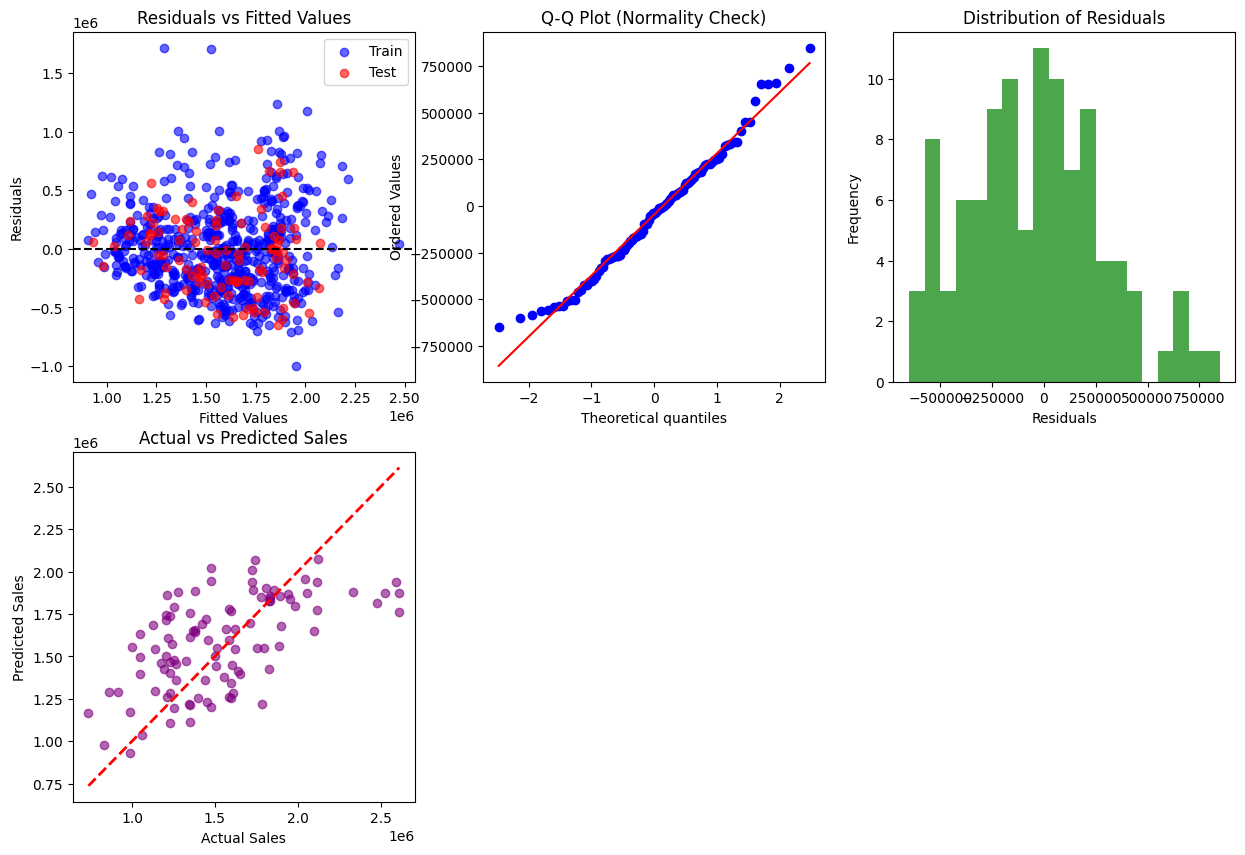

In [18]:
# Create residual plots
plt.figure(figsize=(15, 10))

# Residuals vs Fitted
plt.subplot(2, 3, 1)
plt.scatter(y_train_pred, residuals_train, alpha=0.6, color='blue', label='Train')
plt.scatter(y_test_pred, residuals_test, alpha=0.6, color='red', label='Test')
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.legend()

# Q-Q plot for normality
plt.subplot(2, 3, 2)
stats.probplot(residuals_test, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Check)')

# Residuals distribution
plt.subplot(2, 3, 3)
plt.hist(residuals_test, bins=min(20, len(residuals_test)//3), alpha=0.7, color='green')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')

# Actual vs Predicted
plt.subplot(2, 3, 4)
plt.scatter(y_test, y_test_pred, alpha=0.6, color='purple')
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Actual vs Predicted Sales')

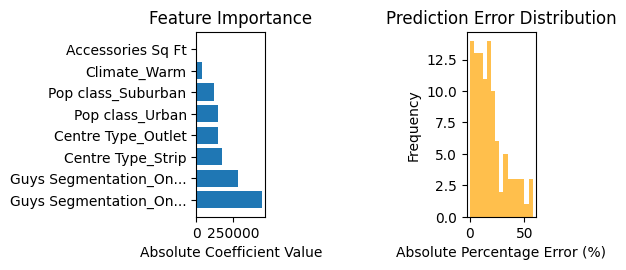

In [19]:
# Feature importance plot
plt.subplot(2, 3, 5)
top_features = feature_importance.head(min(8, len(feature_importance)))
plt.barh(range(len(top_features)), top_features['Abs_Coefficient'])
plt.yticks(range(len(top_features)), [f[:20] + '...' if len(f) > 20 else f for f in top_features['Feature']])
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance')

# Prediction error distribution
plt.subplot(2, 3, 6)
percentage_errors = (np.abs(residuals_test) / y_test) * 100
plt.hist(percentage_errors, bins=min(15, len(percentage_errors)//2), alpha=0.7, color='orange')
plt.xlabel('Absolute Percentage Error (%)')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')

plt.tight_layout()
plt.show()

In [20]:
# BUSINESS INSIGHTS AND RECOMMENDATIONS
print("KEY FINDINGS:")
print(f"• Model explains {test_r2*100:.1f}% of sales variance")
print(f"• Average prediction error: ${test_mae:,.0f} ({(test_mae/y_test.mean())*100:.1f}% of mean sales)")
print(f"• Prediction range: ${y_test_pred.min():,.0f} - ${y_test_pred.max():,.0f}")

KEY FINDINGS:
• Model explains 31.9% of sales variance
• Average prediction error: $264,443 (17.2% of mean sales)
• Prediction range: $932,456 - $2,074,402


In [21]:
print(f"\nTOP SALES DRIVERS:")
for i, (_, row) in enumerate(feature_importance.head(5).iterrows(), 1):
    impact = "increases" if row['Coefficient'] > 0 else "decreases"
    print(f"{i}. {row['Feature']}: {impact} sales by ${abs(row['Coefficient']):,.0f} per unit")


TOP SALES DRIVERS:
1. Guys Segmentation_On trend: decreases sales by $445,073 per unit
2. Guys Segmentation_On Trend: decreases sales by $283,693 per unit
3. Centre Type_Strip: decreases sales by $172,858 per unit
4. Centre Type_Outlet: increases sales by $149,508 per unit
5. Pop class_Urban: increases sales by $144,915 per unit


In [22]:
print("\nMODEL RELIABILITY:")
if test_r2 > 0.7:
    reliability = "HIGH"
    advice = "Model shows strong predictive power - suitable for business decisions"
elif test_r2 > 0.5:
    reliability = "MODERATE" 
    advice = "Model provides reasonable predictions - use with caution"
elif test_r2 > 0.3:
    reliability = "LOW"
    advice = "Model has limited predictive power - consider additional features"
else:
    reliability = "VERY LOW"
    advice = "Model is not reliable for predictions - major revision needed"

print(f"• {reliability}: {advice}")


MODEL RELIABILITY:
• LOW: Model has limited predictive power - consider additional features


In [23]:
print("\nRECOMMENDATIONS:")
print("• Use this model for initial sales estimates for new locations")
print("• Focus on the top sales drivers when selecting store locations")
print("• Regularly retrain the model with new data")
print("• Consider collecting additional data for features not in the current model")


RECOMMENDATIONS:
• Use this model for initial sales estimates for new locations
• Focus on the top sales drivers when selecting store locations
• Regularly retrain the model with new data
• Consider collecting additional data for features not in the current model


In [24]:
# Final summary
mean_abs_percentage_error = np.mean(np.abs(residuals_test) / y_test) * 100
print(f"\nMODEL SUMMARY:")
print(f"• R² Score: {test_r2:.3f}")
print(f"• Mean Absolute Error: ${test_mae:,.0f}")
print(f"• Mean Absolute Percentage Error: {mean_abs_percentage_error:.1f}%")
print(f"• Number of features used: {len(selected_features)}")
print(f"• Training samples: {len(X_train)}")
print(f"• Test samples: {len(X_test)}")


MODEL SUMMARY:
• R² Score: 0.319
• Mean Absolute Error: $264,443
• Mean Absolute Percentage Error: 18.5%
• Number of features used: 9
• Training samples: 587
• Test samples: 104
